In [1]:
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import pandas as pd

import os, sys
sys.path.append(os.path.abspath(".."))

from config import PROJECT_ROOT, DATA_DIR, SCRIPTS_DIR, CSV_PATH

from bitcoin.data import BitcoinDataset
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Modelling Historical Bitcoin Price using a Multi-layer minGRU

### Read in Historical Data

In [2]:
btcusd = BitcoinDataset(csv_path=CSV_PATH, update=False)
btcusd.df.head()

,Datetime,Close
0,2012-01-01 10:01:00,4.58
1,2012-01-01 10:02:00,4.58
2,2012-01-01 10:03:00,4.58
3,2012-01-01 10:04:00,4.58
4,2012-01-01 10:05:00,4.58


In [ ]:
# Scale data
btcusd_scaled = btcusd.scaled_data
(X_train, y_train), _, (X_test, y_test) = btcusd.train_test_split(train_ratio=0.9)

Creating windows of length 3600...


100%|██████████| 7007876/7007876 [00:41<00:00, 169109.70it/s]


### Visualize Train/Test Splits

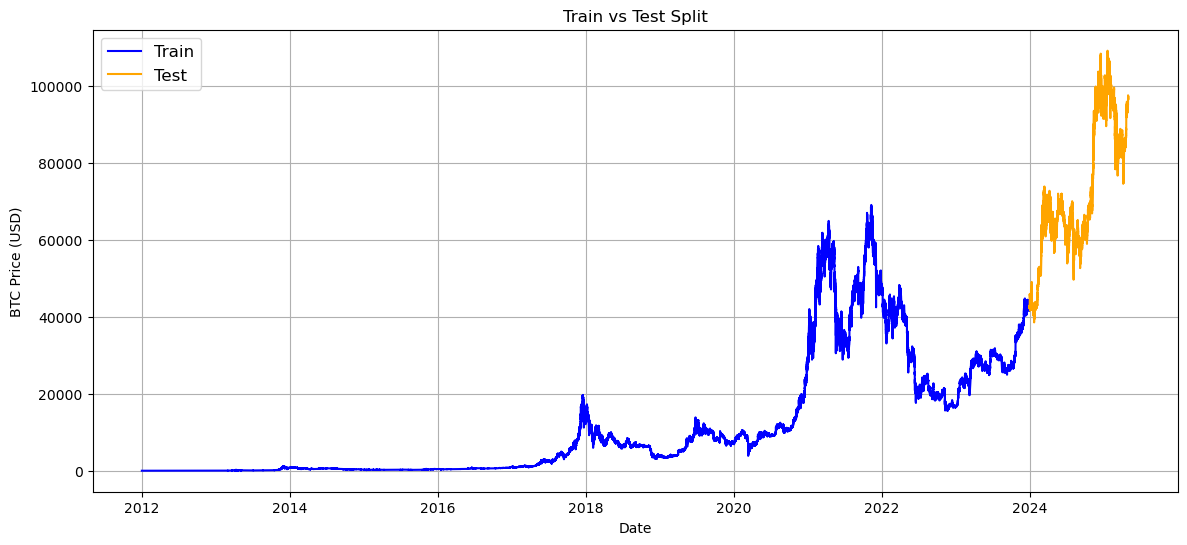

In [9]:
# Recover the full datetime series (excluding the initial window offset)
timestamps = btcusd.df["Datetime"].iloc[btcusd.window_size:].reset_index(drop=True)
prices = btcusd.scaler.inverse_transform(btcusd.scaled_data.numpy()).squeeze()

# Calculate how many points are in each split
n_train = len(X_train)
n_test = len(X_test)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(timestamps[:n_train], prices[btcusd.window_size:btcusd.window_size + n_train], label="Train", color='blue')
plt.plot(timestamps[-n_test:], prices[-n_test:], label="Test", color='orange')
plt.xlabel("Date")
plt.ylabel("BTC Price (USD)")
plt.title("Train vs Test Split")
plt.legend( fontsize='large' )
plt.grid(True)
plt.show()


In [19]:
# X_train = X_train.squeeze(-1)
print("=== Train/Test Dimensions ===\n")
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape, "\n")
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape, "\n")
print("=============================")

=== Train/Test Dimensions ===

X_train:  torch.Size([6310238, 100, 1])
y_train:  torch.Size([6310238]) 

X_test:  torch.Size([701138, 100, 1])
y_test:  torch.Size([701138]) 



In [23]:
train_batch_size = 1024
train_dataset = TensorDataset(X_train, y_train)
train_dl = DataLoader(train_dataset, batch_size=1024, shuffle=True)

In [21]:
class MinGRU(nn.Module):
    def __init__(self, in_dim=1, hidden_dim=16, out_dim=1):
        super().__init__()
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.h = None
        
        # Update gate
        self.update_gate = nn.Sequential(
            nn.Linear(self.in_dim, self.hidden_dim),
            nn.Sigmoid()
        )
        
        # Candidate hidden state
        self.candidate_h_layer = nn.Linear(self.in_dim, self.hidden_dim)
        
        # Final output
        self.output_layer = nn.Linear(self.hidden_dim, self.out_dim)

    def reset(self, batch_size):
        self.h = torch.zeros((batch_size, 1, self.hidden_dim), device=next(self.parameters()).device)

    def step(self, x):
        g = self.update_gate(x)
        candidate_h = self.candidate_h_layer(x)
        self.h = g * candidate_h + (1 - g) * self.h
        return self.output_layer(self.h)

    def forward(self, x_batch):
        """
        Input:
         x_batch: [batch_size, seq_len, in_dim]
        Output:
         y_pred:  [batch_size] — predicted next price
        """
        batch_size, T, _ = x_batch.shape
        self.reset(batch_size)

        for t in range(T):
            x_t = x_batch[:, t, :].unsqueeze(1)  # [batch, 1, in_dim]
            y_t = self.step(x_t)  # output at time t

        return y_t.squeeze(1).squeeze(1)  # final output, shape [batch]


# Multi-layer Deep minGRU

In [22]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DeepminGRU(nn.Module):
    '''
    Deep GRU model for time series regression (e.g., Bitcoin prices per minute)

    Input shape: [batch, seq_len=100, in_dim=1]
    Output: predicted price for the next time step [batch]
    '''
    def __init__(self, n_layers, in_dim, hidden_dim=16):
        super().__init__()
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.losses = []

        self.layers = nn.ModuleList()
        for _ in range(n_layers):
            self.layers.append(MinGRU(in_dim, hidden_dim, in_dim))

        self.output_layer = nn.Linear(hidden_dim, 1)
        self.to(device)

    def reset(self):
        for l in self.layers:
            l.reset()

    def step(self, x):
        # x: [batch, 1, in_dim]
        for layer in self.layers:
            x = layer.step(x)
        x = self.output_layer(x)
        return x  # [batch, 1, 1]

    def forward(self, x):
        # x: [batch, seq_len, in_dim]
        for layer in self.layers:
            x = layer(x)
        x = self.output_layer(x)  # [batch, seq_len, 1]
        return x[:, -1, 0]  # final timestep's predicted price [batch]

    def predict(self, x, n=10):
        with torch.no_grad():
            assert x.shape[0] == 1 and x.shape[2] == self.in_dim
            self.reset()

            for t in range(x.shape[1]):
                y = self.step(x[:, t:t+1, :])

            preds = torch.zeros((1, n)).to(device)
            for i in range(n):
                preds[0, i] = y[0, 0, 0]
                next_input = y.view(1, 1, 1)
                y = self.step(next_input)
            return preds  # shape: [1, n]

    def bptt(self, dl, epochs=10, lr=0.001):
        loss_fcn = nn.MSELoss()
        optim = torch.optim.Adam(self.parameters(), lr=lr)

        for epoch in tqdm(range(epochs)):
            total_loss = 0.
            for x, t in dl:
                x, t = x.to(device), t.to(device)
                y = self(x)  # shape: [batch]
                loss = loss_fcn(y, t)
                optim.zero_grad()
                loss.backward()
                optim.step()
                total_loss += loss.detach().cpu().item() * len(t)

            self.losses.append(total_loss / len(dl.dataset))

        plt.plot(self.losses)
        plt.xlabel('Epoch')
        plt.ylabel('Training Loss')
        plt.title('BPTT Training Loss')
        plt.grid(True)
        plt.show()


In [24]:
net = DeepminGRU(n_layers=2, in_dim=1, hidden_dim=64)
net.bptt(train_dl, epochs=5, lr=1e-3)

  0%|          | 0/5 [00:00<?, ?it/s]


RuntimeError: expected m1 and m2 to have the same dtype, but got: double != float